In [ ]:
%%bash
if ! conda env list | grep microexpressions; then
    conda env create -f environment.yml
else
    conda env update -f environment.yml
fi
conda activate microexpressions
dvc pull

In [29]:
import sys
import os
PROJ_PATH = os.getcwd()
SRC_PATH = os.path.join(PROJ_PATH, 'src')
sys.path.append(PROJ_PATH)
sys.path.append(SRC_PATH)
%load_ext autoreload
%autoreload 2

Device: cpu


e:\Programs\miniconda\envs\microexpressions\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


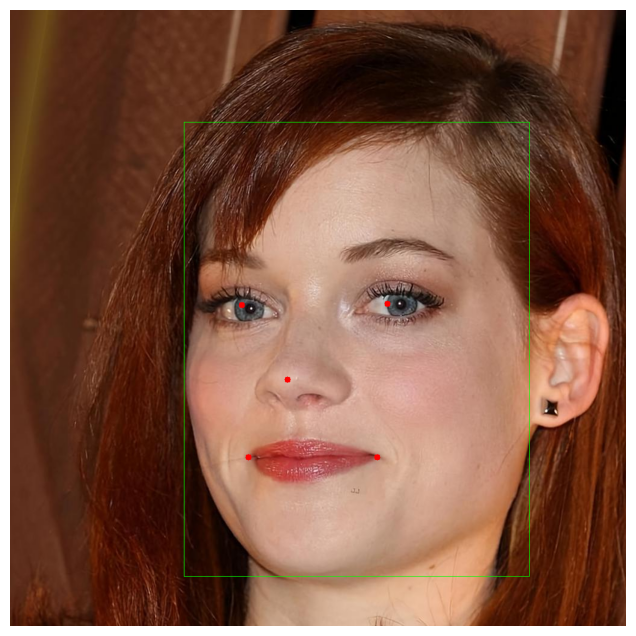

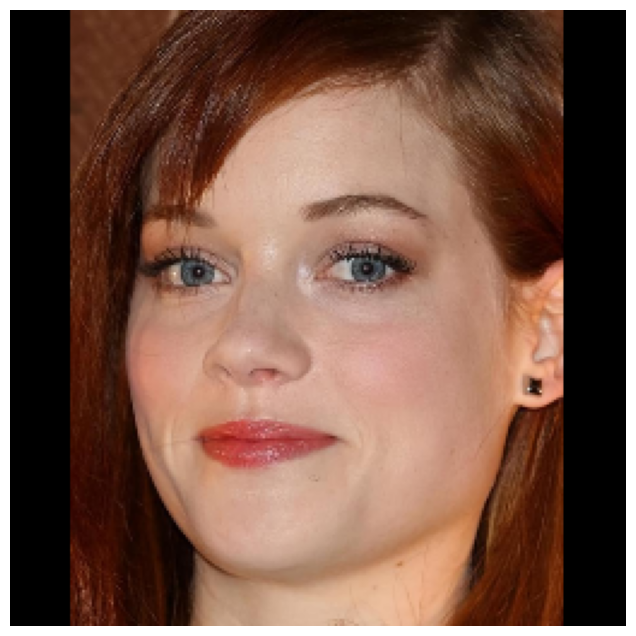

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from src.alignment import detect_faces, align_face

PROJ_PATH = os.getcwd()
DATA_DIR = os.path.join(PROJ_PATH, 'data')
MODEL_DIR = os.path.join(PROJ_PATH, 'models')

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

image_path = os.path.join(DATA_DIR, "raw", r"celeba_hq", "000942.jpg")
model_path = os.path.join(MODEL_DIR, "yolov6s_face.onnx")
image, detections = detect_faces(image_path, model_path)

source_image = image.copy()
for det in detections[:1]:
    x1, y1, x2, y2 = map(int, det["bbox"])
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    for x, y in det["landmarks"]:
        cv2.circle(image, (int(x), int(y)), 5, (255, 0, 0), -1)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

aligned_image = align_face(source_image, np.array(detections[0]["landmarks"]), detections[0]["bbox"], output_size=(256, 256))
plt.figure(figsize=(8, 8))
plt.imshow(aligned_image)
plt.axis("off")
plt.show()

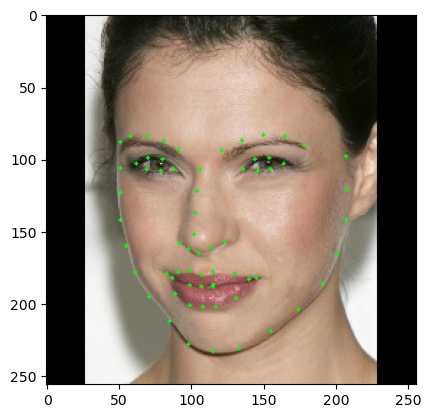

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from src.demo_helpers import plot_landmarks_cv2
import os
import cv2

df = pd.read_hdf(r"data\landmarks\lm_celeba_hq_starnet.h5")
row = df.iloc[33]
filename = row["filename"]
image_path = os.path.join(r"data\processed\aligned_celeba_hq", filename)
plt.imshow(cv2.cvtColor(plot_landmarks_cv2(image_path, row), cv2.COLOR_BGR2RGB))

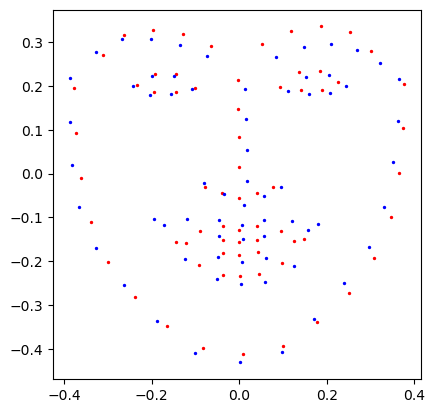

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from src.procrustes import *

meanface = load_meanface(r"models\meanface.txt")

df = pd.read_hdf(r"data\landmarks\lm_celeba_hq_starnet.h5")
row = df.iloc[78]
fragment_landmarks = row[[ind for ind in row.index if re.match(r'(n_)?[xy]\d+', ind)]]
face = fragment_landmarks.to_numpy().reshape(-1, 2).astype(np.float32)
normalized_face, _, _, _ = normalize_single_face_with_params(face, meanface)

plt.scatter(meanface[:, 0], -meanface[:, 1], c='red', s=2)
plt.scatter(normalized_face[:, 0], -normalized_face[:, 1], c='blue', s=2)
plt.gca().set_aspect('equal')

In [25]:
from src.demo_helpers import plot_emb_with_images
import pandas as pd

viz_df = pd.read_hdf(r'data\landmarks\umap2_pr_lm_celeba_hq_starnet.h5')
lm_df = pd.read_hdf(r'data\landmarks\lm_celeba_hq_starnet.h5')
plot_emb_with_images(viz_df, lm_df, n_clusters=20, n_reps_per_cluster=2, random_state=2)

In [26]:
from src.extract_facial_features_and_filter import *

pr_lm_df = pd.read_hdf(r'data\landmarks\pr_lm_celeba_hq_starnet.h5')
angles_filter = get_angles_filter(pr_lm_df, 5, 5)
viz_df['color'] = angles_filter
plot_emb_with_images(viz_df, lm_df, n_clusters=20, n_reps_per_cluster=2, random_state=2)

In [27]:
viz_df = viz_df[angles_filter]
clusters = get_clusters(pr_lm_df, angles_filter, clustering_dim = 2, verbose=False)
values, counts = np.unique(clusters[clusters >= 0], return_counts=True)
main_cluster = values[counts.argmax()]
viz_df['color'] = clusters == main_cluster
plot_emb_with_images(viz_df, lm_df, n_clusters=20, n_reps_per_cluster=2, random_state=2)

e:\Programs\miniconda\envs\microexpressions\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [30]:
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from src.types_of_faces import *

feat_df = pd.read_hdf(r"data\landmarks\features_celeba_hq_starnet.h5")
cells, x_quantiles, y_quantiles = get_cells(feat_df, 3, 5)
X = feat_df.select_dtypes(include=['float64'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=feat_df.columns[:-1])
df_scaled['cell'] = pd.read_hdf(r"data\landmarks\typed_features_celeba_hq_starnet.h5")['face_type'].to_numpy()

fig = px.scatter(df_scaled, x = 'eye_distance', y = 'eyes_mouth_distance', color='cell', width=1200, height=600)
for x_val in x_quantiles:
    fig.add_vline(x=x_val, line=dict(color='black', dash='dash'))
for y_val in y_quantiles:
    fig.add_hline(y=y_val, line=dict(color='black', dash='dash'))

fig.show()

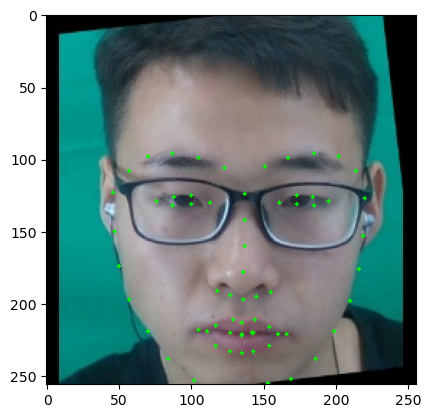

In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from src.demo_helpers import plot_landmarks_cv2
row_num = 19
fragment_name = 'spNO.206_g_113'
df = pd.read_csv(fr"data\me_landmarks\casme3\{fragment_name}\raw_landmarks.csv", sep=';')
row = df.iloc[row_num]
filename = row["filename"]
image_path = os.path.join(fr"data\raw\casme3_partA\frame\{fragment_name}_aligned", filename)
plt.imshow(cv2.cvtColor(plot_landmarks_cv2(image_path, row), cv2.COLOR_BGR2RGB))

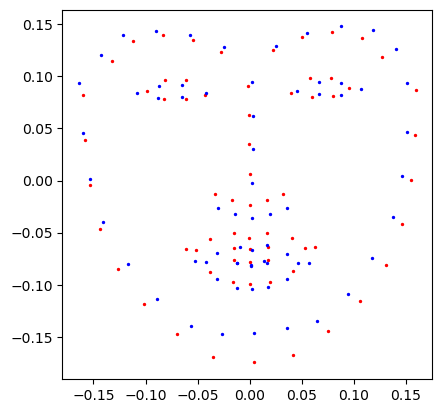

In [8]:
import numpy as np
from src.procrustes import *

meanface_file = r"models\meanface.txt"
with open(meanface_file) as f:
    meanface = f.readlines()[0]

meanface = meanface.strip().split()
meanface = [float(x) for x in meanface]
meanface = np.array(meanface).reshape(-1, 2)

meanface_n, _, _ = normalize_points(meanface)
df = pd.read_csv(fr"data\me_landmarks\casme3\{fragment_name}\procrustes_lm.csv", sep=';')
row = df.iloc[row_num]
fragment_landmarks = row[[ind for ind in row.index if re.match(r'(n_)?[xy]\d+', ind)]]
face = fragment_landmarks.to_numpy().reshape(-1, 2).astype(np.float32)

plt.scatter(meanface_n[:,0], -meanface_n[:, 1], c='red', s=2)
plt.scatter(face[:,0], -face[:, 1], c='blue', s=2)
plt.gca().set_aspect('equal')

In [33]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import os

fragment_base_path = r'data\augmented\casme3\spNO.10_i_2864'
# fragment_base_path = r'data\augmented\casme3\spNO.215_k_1505'
au_fragment_path = os.path.join(fragment_base_path, os.listdir(fragment_base_path)[0])

au_fragment_df = pd.read_csv(au_fragment_path, sep=';', index_col=0)
original_fragment_df = pd.read_csv(os.path.join(fragment_base_path, 'procrustes_lm_original.csv'), sep=';', index_col=0)

original_fragment_lm = []
au_fragment_lm = []
coord_columns = [col for col in original_fragment_df.columns if re.match(r'(n_)?[xy]\d+', col)]
for i in range(len(original_fragment_df)):
    original_row = original_fragment_df.iloc[i]
    original_lm = original_row[coord_columns]
    original_fragment_lm.append(original_lm.values.reshape(-1, 2))
    au_row = au_fragment_df.iloc[i]
    au_lm = au_row[coord_columns]
    au_fragment_lm.append(au_lm.values.reshape(-1, 2))

num_frames = len(original_fragment_lm)
num_points = 68
data = []
for frame in range(num_frames):
    for i in range(num_points):
        data.append({'frame': frame, 'point_id': f'me_{i}', 'x': original_fragment_lm[frame][i, 0] - 0.5, 'y': -original_fragment_lm[frame][i, 1], 'group': 'ME'})
    for i in range(num_points):
        data.append({'frame': frame, 'point_id': f'au_me_{i}', 'x': au_fragment_lm[frame][i, 0], 'y': -au_fragment_lm[frame][i, 1], 'group': 'AUGMENTED_ME'})

df = pd.DataFrame(data)
fig = go.Figure()
for group in ['ME', 'AUGMENTED_ME']:
    group_df = df[df['group'] == group]
    fig.add_trace(
        go.Scatter(
            x=group_df[group_df['frame'] == 0]['x'],
            y=group_df[group_df['frame'] == 0]['y'],
            mode='markers',
            marker=dict(size=8, color='red' if group == 'ME' else 'blue'),
            name=group
        )
    )
frames = []
for frame in range(num_frames):
    frame_data = []
    for group in ['ME', 'AUGMENTED_ME']:
        group_df = df[(df['frame'] == frame) & (df['group'] == group)]
        frame_data.append(
            go.Scatter(
                x=group_df['x'],
                y=group_df['y'],
                mode='markers',
                marker=dict(size=8, color='red' if group == 'ME' else 'blue')
            )
        )
    frames.append(go.Frame(data=frame_data, name=str(frame)))
fig.update(frames=frames)
fig.update_layout(
    width=1400,
    height=700,
    xaxis=dict(range=[-0.8, 0.3], title="X"),
    yaxis=dict(range=[-0.2, 0.2], title="Y", scaleanchor="x", scaleratio=1),
    showlegend=True,
    sliders=[dict(
        steps=[dict(method="animate", args=[[str(k)], {"frame": {"duration": 400, "redraw": True}, "mode": "immediate"}], label=str(k)) for k in range(num_frames)],
        active=0,
        transition={"duration": 0},
        x=0,
        y=0,
        len=1.0
    )]
)
fig.show()